In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score,confusion_matrix, recall_score, precision_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
import imblearn
from imblearn.over_sampling import SMOTE

import warnings; warnings.simplefilter('ignore')

Using TensorFlow backend.


***
## Conditioning

We begin by loading in our cleaned data set: 

In [2]:
df = pd.read_csv('Crime_data_final.csv')

In [3]:
df.head()

,Unnamed: 0,REPORT_DAT,SHIFT,METHOD,OFFENSE,WARD,DISTRICT,NEIGHBORHOOD_CLUSTER,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,OBJECTID,OCTO_RECORD_ID,COUNT,CITY,STATE,DATE,TIME
0,0,2018-12-22T21:10:50.000Z,EVENING,OTHERS,THEFT/OTHER,4,4.0,Cluster 18,002301 2,2301.0,Precinct 45,38.942182,-77.014557,329684676,18217166-01,1,"Washington, DC",District of Columbia,2018-12-22,21:10:50
1,1,2018-12-22T20:29:36.000Z,EVENING,OTHERS,THEFT/OTHER,6,1.0,Cluster 27,007200 2,7200.0,Precinct 131,38.876999,-77.004356,329684677,18217171-01,1,"Washington, DC",District of Columbia,2018-12-22,20:29:36
2,2,2018-12-23T03:38:37.000Z,MIDNIGHT,OTHERS,THEFT/OTHER,7,6.0,Cluster 32,009603 3,9603.0,Precinct 102,38.890214,-76.952775,329684678,18217172-01,1,"Washington, DC",District of Columbia,2018-12-23,03:38:37
3,3,2018-12-22T21:00:57.000Z,EVENING,OTHERS,MOTOR VEHICLE THEFT,7,6.0,Cluster 33,007803 3,7803.0,Precinct 98,38.890241,-76.935370,329684679,18217180-01,1,"Washington, DC",District of Columbia,2018-12-22,21:00:57
4,4,2018-12-22T20:49:59.000Z,EVENING,OTHERS,THEFT F/AUTO,2,1.0,Cluster 8,005800 2,5800.0,Precinct 129,38.900860,-77.020912,329684680,18217182-01,1,"Washington, DC",District of Columbia,2018-12-22,20:49:59


And drop the unnecessary columns: 

In [4]:
df = df.drop(columns = ['Unnamed: 0', 'COUNT', 'CITY', 'STATE', 'REPORT_DAT', 'OCTO_RECORD_ID'])

Next we split our feature and label data:

In [5]:
y = df.OFFENSE
df = df.drop(columns = 'OFFENSE')

Some of our feature variables include text data. We'll need to split these columns and include only the integer values:

In [6]:
df['NEIGHBORHOOD_CLUSTER'] = df['NEIGHBORHOOD_CLUSTER'].str.split(' ').str[1]
df['VOTING_PRECINCT'] = df['VOTING_PRECINCT'].str.split(' ').str[1]

Further, we'll isolate our date and time features by their component parts (i.e., day, month, year):

In [7]:
df['YEAR'] = df['DATE'].str.split('-').str[0]
df['MONTH'] = df['DATE'].str.split('-').str[1]
df['DAY'] = df['DATE'].str.split('-').str[2]

df['HOUR'] = df['TIME'].str.split(':').str[0]
df['MINUTE'] = df['TIME'].str.split(':').str[1]
df['SECOND'] = df['TIME'].str.split(':').str[2]

In [8]:
df = df.drop(columns = ['DATE', 'TIME'])

In order to keep the 'BLOCK_GROUP' data, we'll need to remove the space included within the data: 

In [10]:
df['BLOCK_GROUP'] = df['BLOCK_GROUP'].str.replace(" ","")

And convert the string (object) variables to integers:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53654 entries, 0 to 53653
Data columns (total 17 columns):
SHIFT                   53654 non-null object
METHOD                  53654 non-null object
WARD                    53654 non-null int64
DISTRICT                53654 non-null float64
NEIGHBORHOOD_CLUSTER    53654 non-null object
BLOCK_GROUP             53654 non-null object
CENSUS_TRACT            53654 non-null float64
VOTING_PRECINCT         53654 non-null object
LATITUDE                53654 non-null float64
LONGITUDE               53654 non-null float64
OBJECTID                53654 non-null int64
YEAR                    53654 non-null object
MONTH                   53654 non-null object
DAY                     53654 non-null object
HOUR                    53654 non-null object
MINUTE                  53654 non-null object
SECOND                  53654 non-null object
dtypes: float64(4), int64(2), object(11)
memory usage: 7.0+ MB


In [12]:
df['DISTRICT'] = df['DISTRICT'].astype(int)
df['NEIGHBORHOOD_CLUSTER'] = df['NEIGHBORHOOD_CLUSTER'].astype(int)
df['BLOCK_GROUP'] = df['BLOCK_GROUP'].astype(int)
df['VOTING_PRECINCT'] = df['VOTING_PRECINCT'].astype(int)
df['DISTRICT'] = df['DISTRICT'].astype(int)

df['YEAR'] = df['YEAR'].astype(int)
df['MONTH'] = df['MONTH'].astype(int)
df['DAY'] = df['DAY'].astype(int)

df['HOUR'] = df['HOUR'].astype(int)
df['MINUTE'] = df['MINUTE'].astype(int)
df['SECOND'] = df['SECOND'].astype(int)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53654 entries, 0 to 53653
Data columns (total 17 columns):
SHIFT                   53654 non-null object
METHOD                  53654 non-null object
WARD                    53654 non-null int64
DISTRICT                53654 non-null int64
NEIGHBORHOOD_CLUSTER    53654 non-null int64
BLOCK_GROUP             53654 non-null int64
CENSUS_TRACT            53654 non-null float64
VOTING_PRECINCT         53654 non-null int64
LATITUDE                53654 non-null float64
LONGITUDE               53654 non-null float64
OBJECTID                53654 non-null int64
YEAR                    53654 non-null int64
MONTH                   53654 non-null int64
DAY                     53654 non-null int64
HOUR                    53654 non-null int64
MINUTE                  53654 non-null int64
SECOND                  53654 non-null int64
dtypes: float64(3), int64(12), object(2)
memory usage: 7.0+ MB


***
## Feature Engineering

The first piece of our feature engineering phase requires us to address the categorical features from the 'shift' and 'method' columns. We'll address this by dummifying the columns:

In [14]:
display(df.SHIFT.unique())
display(df.METHOD.unique())

array(['EVENING', 'MIDNIGHT', 'DAY'], dtype=object)

array(['OTHERS', 'GUN', 'KNIFE'], dtype=object)

In [15]:
df = pd.get_dummies(df)

In [16]:
print('Final feature dataset shape:',df.shape)
print()
display(df.head())

Final feature dataset shape: (53654, 21)



,WARD,DISTRICT,NEIGHBORHOOD_CLUSTER,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,OBJECTID,YEAR,...,DAY,HOUR,MINUTE,SECOND,SHIFT_DAY,SHIFT_EVENING,SHIFT_MIDNIGHT,METHOD_GUN,METHOD_KNIFE,METHOD_OTHERS
0,4,4,18,23012,2301.0,45,38.942182,-77.014557,329684676,2018,...,22,21,10,50,0,1,0,0,0,1
1,6,1,27,72002,7200.0,131,38.876999,-77.004356,329684677,2018,...,22,20,29,36,0,1,0,0,0,1
2,7,6,32,96033,9603.0,102,38.890214,-76.952775,329684678,2018,...,23,3,38,37,0,0,1,0,0,1
3,7,6,33,78033,7803.0,98,38.890241,-76.935370,329684679,2018,...,22,21,0,57,0,1,0,0,0,1
4,2,1,8,58002,5800.0,129,38.900860,-77.020912,329684680,2018,...,22,20,49,59,0,1,0,0,0,1


Next we address our label data. We start by taking a look at the distribution of our labels to determine whether or not we'll need to rebalance the dataset: 

In [19]:
print('Number of offense categories:', y.nunique())
print()
print('Frequency of each offense category:')
print()
print(y.value_counts())

Number of offense categories: 9

Frequency of each offense category:

THEFT/OTHER                   23219
THEFT F/AUTO                  17917
MOTOR VEHICLE THEFT            3695
ROBBERY                        3319
ASSAULT W/DANGEROUS WEAPON     2634
BURGLARY                       2210
SEX ABUSE                       389
HOMICIDE                        261
ARSON                            10
Name: OFFENSE, dtype: int64


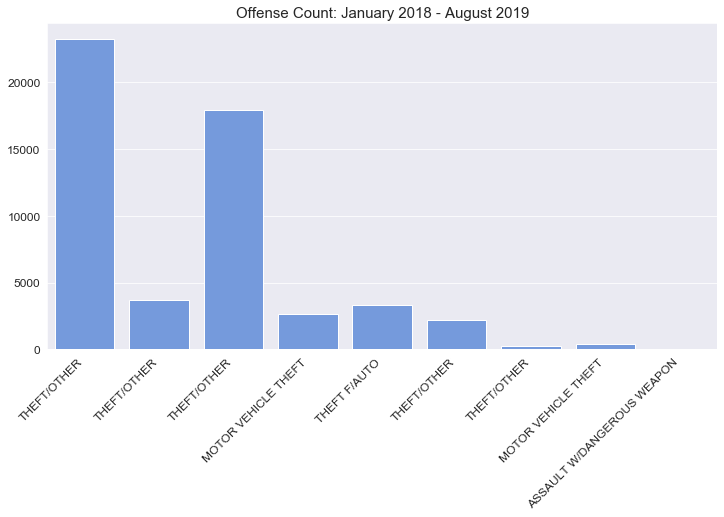

In [20]:
sns.set_style('darkgrid')

plt.figure(figsize= (12,6))

g = sns.countplot(x = y, color = 'cornflowerblue')
g.set_xticklabels(rotation = 45, labels = y, horizontalalignment='right')

plt.title('Offense Count: January 2018 - August 2019', size = 15)
plt.ylabel('')
plt.xlabel('')
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

Based on the extreme imbalance of our target variable, we'll need to employ some rebalancing using the SMOTE method. Before doing so, let's convert our target variable to integers:

In [21]:
y = y.astype('category')
encoded_labels = y.cat.codes
encoded_labels.head()

0    8
1    8
2    8
3    4
4    7
dtype: int8

For later model testing, we'll save our conditioned dataset so we can recall it once our model is trained:

In [22]:
test_df = df
test_df['TARGET'] = y

In [23]:
test_df.to_csv('Model_test_data.csv')

With our labels encoded, we can move on to rebalancing the dataset: 

In [24]:
y = encoded_labels
df.drop(columns = 'TARGET', inplace = True)
x = df

In [25]:
print('Target value counts pre resampling:')
print(y.value_counts())
print()

x_resampled, y_resampled = SMOTE().fit_sample(x,y)

print('Target value counts post resampling:')
print(pd.Series(y_resampled).value_counts())

resampled_feats = pd.DataFrame(x_resampled, columns = df.columns)
target = y_resampled

Target value counts pre resampling:
8    23219
7    17917
4     3695
5     3319
1     2634
2     2210
6      389
3      261
0       10
dtype: int64

Target value counts post resampling:
8    23219
7    23219
6    23219
5    23219
4    23219
3    23219
2    23219
1    23219
0    23219
dtype: int64


Let's confirm our feature and target set are of the same length after our resampling:

In [26]:
print('Number of instances in our feature set:', len(resampled_feats))
print('Number of labels in our target set:', len(target))

Number of instances in our feature set: 208971
Number of labels in our target set: 208971


As a last step in the feature engineering phase, we'll employ the Standard Scaler function from SKlearn to achieve a uniform scale of our data. We'll do this to avoid outsized impacts certain features may have on our classification models:

In [29]:
column_names = resampled_feats.columns

scaler = StandardScaler()
scaled_feats = scaler.fit_transform(resampled_feats)

scaled_feats = pd.DataFrame(scaled_feats, columns = column_names)

features = scaled_feats
features.head()

,WARD,DISTRICT,NEIGHBORHOOD_CLUSTER,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,OBJECTID,YEAR,...,DAY,HOUR,MINUTE,SECOND,SHIFT_DAY,SHIFT_EVENING,SHIFT_MIDNIGHT,METHOD_GUN,METHOD_KNIFE,METHOD_OTHERS
0,-0.467943,-0.169718,-0.274335,-1.561826,-1.561825,-0.851633,1.321831,-0.444080,-5.746527,-0.846619,...,0.859693,1.340580,-0.991370,1.493689,-0.700483,1.436636,-0.789338,-0.50432,-0.283952,0.591874
1,0.397275,-1.769479,0.479092,0.134095,0.134086,1.374872,-0.710777,-0.155034,-5.746519,-0.846619,...,0.859693,1.198706,0.125175,0.654819,-0.700483,1.436636,-0.789338,-0.50432,-0.283952,0.591874
2,0.829884,0.896790,0.897662,0.965994,0.965944,0.624074,-0.298701,1.306521,-5.746511,-0.846619,...,0.988397,-1.213139,0.654065,0.714738,-0.700483,-0.882158,1.528923,-0.50432,-0.283952,0.591874
3,0.829884,0.896790,0.981376,0.342875,0.342829,0.520516,-0.297837,1.799702,-5.746503,-0.846619,...,0.859693,1.340580,-1.579026,1.913124,-0.700483,1.436636,-0.789338,-0.50432,-0.283952,0.591874
4,-1.333161,-1.769479,-1.111475,-0.350553,-0.350559,1.323093,0.033289,-0.624157,-5.746495,-0.846619,...,0.859693,1.198706,1.300486,2.032962,-0.700483,1.436636,-0.789338,-0.50432,-0.283952,0.591874


Before finishing this section, we're going to combine our features and target data in one dataframe and save the file as a CSV for easy when running our classifiers down:

In [32]:
features['TARGET'] = target
modeling_df = features

In [33]:
modeling_df.to_csv('Modeling_data_final.csv')

## Modeling

With the data prepped for modeling, we'll load in the modeling data, split our target and features, and split our train and test set:

In [11]:
df = pd.read_csv('Modeling_data_final.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
features = df.drop(columns = ['TARGET'])
target = df.TARGET

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .20)

We're going to run a few classifier algorithms and assess the best performer based on the average accuracy score using KFold cross validation:

In [168]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('ADB', AdaBoostClassifier()))

seed = 42
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    
    kfold = model_selection.KFold(n_splits = 20, random_state = seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring)
    
    results.append(cv_results)
    names.append(name)
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    
    print(msg)

KNN: 0.777576 (0.003145)
DT: 0.751005 (0.003537)
NB: 0.413660 (0.005780)
RF: 0.821081 (0.003836)
ADB: 0.306240 (0.013761)


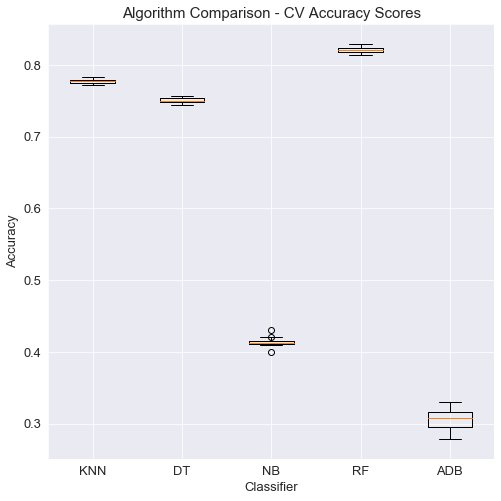

In [169]:
plt.figure(figsize=(8,8))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison - CV Accuracy Scores', size = 15)
plt.xlabel('Classifier', size = 13)
plt.ylabel('Accuracy', size = 13)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

Based on the above results, it's clear the random forest algorithm yields the best results with respect to accuracy scores. Our next step is to run a grid search using varying random forest hyper parameters in an attempt to flush out the best final model: 

In [38]:
param_grid = { 
    'n_estimators': [50, 100, 150],
    'max_depth' : [5, 15, 30],
    'min_samples_leaf' : [1, 5, 10],
    'criterion' : ['gini', 'entropy']
}

In [ ]:
rfc = RandomForestClassifier(random_state = 42)

CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 3)
CV_rfc.fit(X_train, y_train)

In [ ]:
print('Optimal hyperparameters for max accuracy score:', CV_rfc.best_params_)

With the retrieval of the best parameters, let's re-run the algorithm and test the model against our testing set: 

In [39]:
rfc = RandomForestClassifier(random_state = 42, criterion = 'gini', max_depth = 30, 
                             min_samples_leaf = 1, n_estimators = 150, verbose = 0)

trained_model = rfc.fit(X_train, y_train)

**Model Evaluation**

With our trained model, we'll make predictions using the feature test set and compare it to the actual labels using the target test set:

In [40]:
predictions = trained_model.predict(X_test)

In [41]:
print('Random Forest model accuracy: ', accuracy_score(y_test, predictions))

Random Forest model accuracy:  0.8610120827850222


With our model predictions assessed against our actual labels, we'll take a look at the confusion matrix produced by our models predictions: 

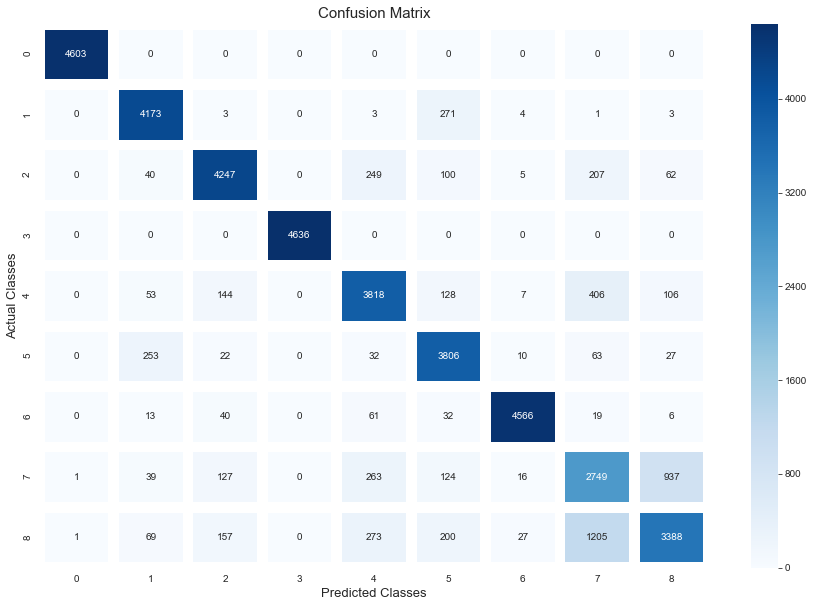

In [42]:
cnf_matrix = confusion_matrix(predictions, y_test)

plt.figure(figsize=(15,10))
sns.heatmap(cnf_matrix, annot = True, fmt = 'd', cmap= 'Blues', linewidths=10, )
plt.title('Confusion Matrix', size= 15)
plt.xlabel('Predicted Classes', size = 13)
plt.ylabel('Actual Classes', size = 13)

plt.show()

With our modeled assessed for accuracy, we'll step back and look at the features of most importance in determining the type of crime that took place:

In [43]:
feature_importances = pd.Series(trained_model.feature_importances_, 
                                index = features.columns).sort_values(ascending = False)
feature_importances

SECOND                  0.103521
MINUTE                  0.082732
HOUR                    0.071523
OBJECTID                0.070336
LONGITUDE               0.068128
BLOCK_GROUP             0.055126
LATITUDE                0.054730
METHOD_OTHERS           0.053645
MONTH                   0.050786
CENSUS_TRACT            0.048140
DAY                     0.047931
VOTING_PRECINCT         0.042392
NEIGHBORHOOD_CLUSTER    0.033362
METHOD_GUN              0.033027
DISTRICT                0.029117
SHIFT_MIDNIGHT          0.027608
YEAR                    0.027601
SHIFT_EVENING           0.026898
WARD                    0.026477
METHOD_KNIFE            0.024685
SHIFT_DAY               0.022237
dtype: float64

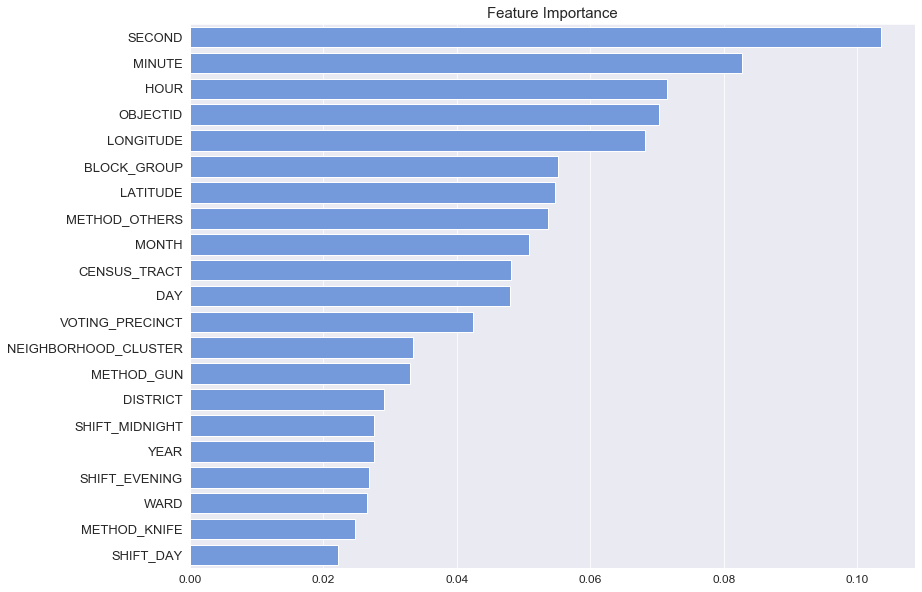

In [47]:
plt.figure(figsize=(13,10))

sns.barplot(x = feature_importances, y = feature_importances.index, color = 'cornflowerblue')
plt.title('Feature Importance', size = 15)
plt.yticks(size = 13)
plt.xticks(size = 12)
plt.show()


**Principal Component Analysis** 

Out of curiosity, I decided to visualize

In [38]:
df = pd.read_csv('Modeling_data_final.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
features = df.drop(columns = ['TARGET'])
target = df.TARGET

In [39]:
pca = PCA(n_components = 2)

principal_components = pca.fit_transform(features)

principal_df = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2'])

In [40]:
pca_df = pd.concat([principal_df, target], axis = 1)
pca_df.head()

,principal component 1,principal component 2,TARGET
0,2.707524,-0.767508,8
1,0.116498,-1.883655,8
2,-2.301726,0.284738,8
3,-1.476833,-2.198402,4
4,2.304247,-1.821605,7


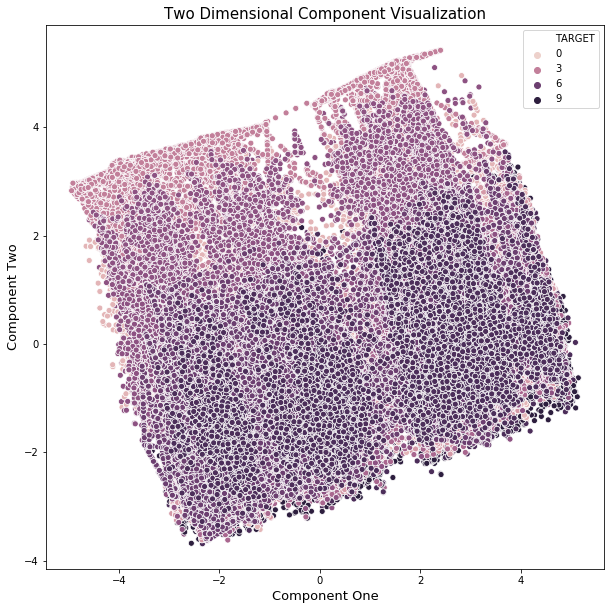

In [41]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'principal component 1', y = 'principal component 2', hue = 'TARGET', data = pca_df)
plt.title('Two Dimensional Component Visualization', size = (15))
plt.xlabel('Component One', size = 13)
plt.ylabel('Component Two', size = 13)
plt.show()

**Final Model**

Although the second and minute data appear most important, we're going to run our random forest classifier once more without these features. The time reported on crime data could be subject to human influence, et cetera, as such granular data about the exact timing of a crime is likely subject to error.

We'll start by removing the minute and second features:

In [13]:
X_train.drop(columns = ['SECOND', 'MINUTE'], inplace = True)
X_test.drop(columns = ['SECOND', 'MINUTE'], inplace = True)

In [16]:
rfc_2 = RandomForestClassifier(random_state = 42, criterion = 'gini', max_depth = 30, 
                             min_samples_leaf = 1, n_estimators = 150, verbose = 0)

trained_model_2 = rfc_2.fit(X_train, y_train)

In [18]:
predictions_2 = trained_model_2.predict(X_test)

In [20]:
print('Random Forest model accuracy sans minute and second features: ', accuracy_score(y_test, predictions_2))

Random Forest model accuracy sans minute and second features:  0.8522789807393228


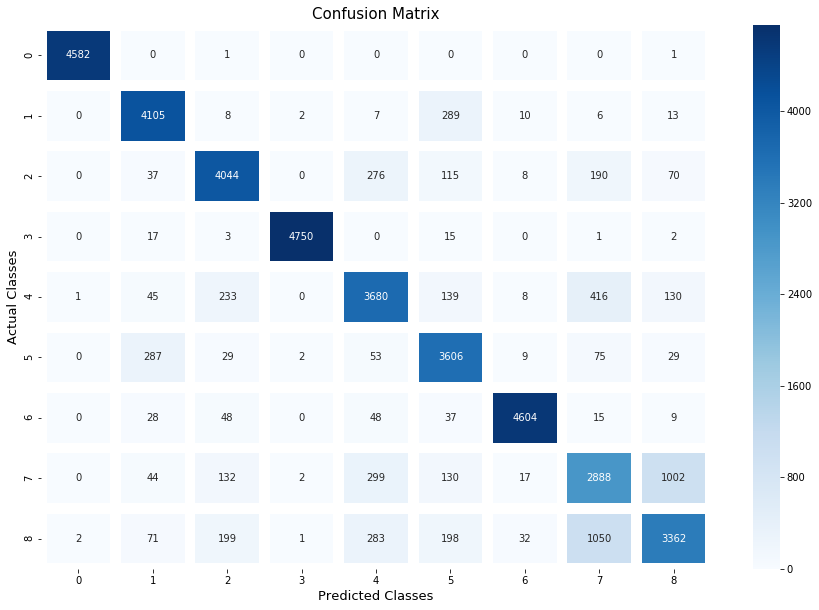

In [21]:
cnf_matrix = confusion_matrix(predictions_2, y_test)

plt.figure(figsize=(15,10))
sns.heatmap(cnf_matrix, annot = True, fmt = 'd', cmap= 'Blues', linewidths=10, )
plt.title('Confusion Matrix', size= 15)
plt.xlabel('Predicted Classes', size = 13)
plt.ylabel('Actual Classes', size = 13)

plt.show()

In [24]:
feature_importances_2 = pd.Series(trained_model_2.feature_importances_, 
                                index = X_train.columns).sort_values(ascending = False)
feature_importances_2

HOUR                    0.122231
OBJECTID                0.087040
LONGITUDE               0.080231
LATITUDE                0.066324
BLOCK_GROUP             0.063504
MONTH                   0.063080
DAY                     0.059440
METHOD_OTHERS           0.058329
CENSUS_TRACT            0.056215
VOTING_PRECINCT         0.048924
NEIGHBORHOOD_CLUSTER    0.038473
SHIFT_MIDNIGHT          0.037478
METHOD_GUN              0.036545
DISTRICT                0.034372
SHIFT_EVENING           0.033533
YEAR                    0.031240
WARD                    0.031103
SHIFT_DAY               0.026974
METHOD_KNIFE            0.024966
dtype: float64

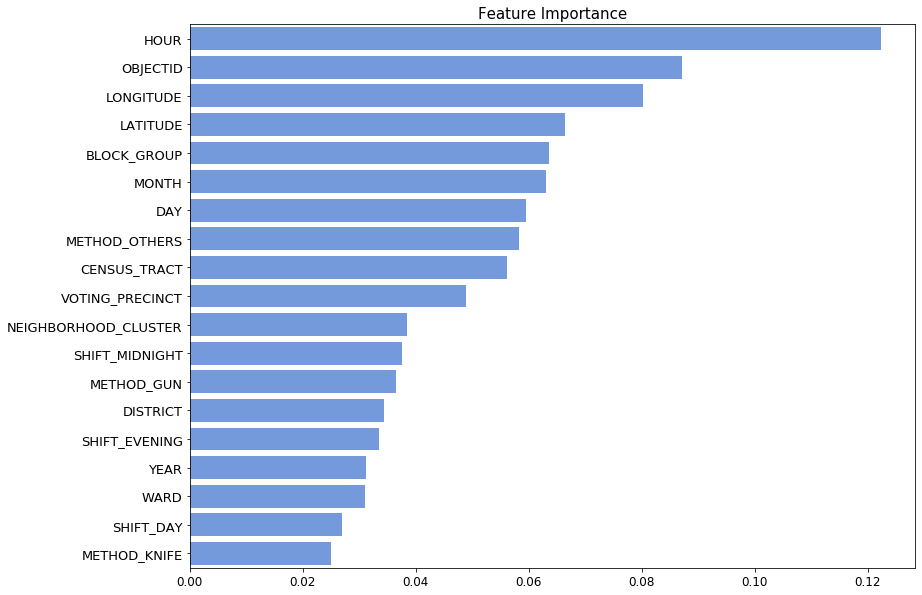

In [26]:
plt.figure(figsize=(13,10))

sns.barplot(x = feature_importances_2, y = feature_importances_2.index, color = 'cornflowerblue')
plt.title('Feature Importance', size = 15)
plt.yticks(size = 13)
plt.xticks(size = 12)
plt.show()

In [28]:
df = pd.read_csv('Modeling_data_final.csv')
df.drop(columns = ['Unnamed: 0', 'MINUTE', 'SECOND'], inplace = True)
features = df.drop(columns = ['TARGET'])
target = df.TARGET

In [31]:
pca_2 = PCA(n_components = 2)

principal_components_2 = pca_2.fit_transform(features)

principal_df_2 = pd.DataFrame(data = principal_components_2, columns = ['principal component 1', 'principal component 2'])

In [32]:
pca_df_2 = pd.concat([principal_df_2, target], axis = 1)
pca_df_2.head()

,principal component 1,principal component 2,TARGET
0,2.645368,-0.999680,8
1,-0.033610,-1.818283,8
2,-2.448695,0.925223,8
3,-1.618407,-2.195316,4
4,1.928152,-1.276724,7


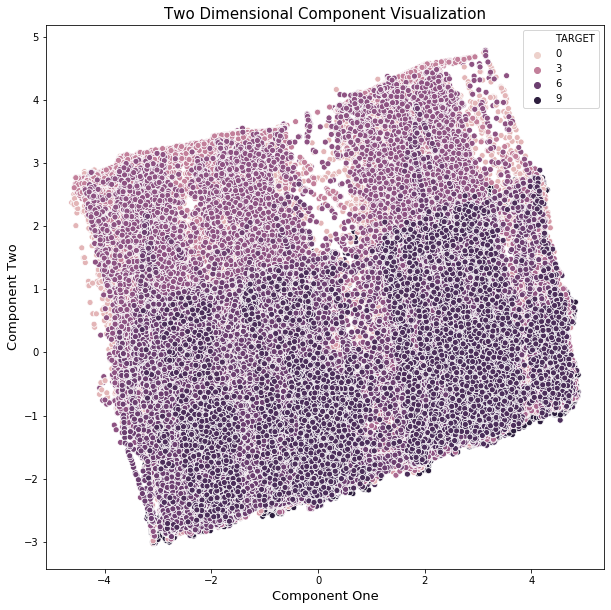

In [36]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'principal component 1', y = 'principal component 2', hue = 'TARGET', data = pca_df_2)
plt.title('Two Dimensional Component Visualization', size = (15))
plt.xlabel('Component One', size = 13)
plt.ylabel('Component Two', size = 13)
plt.show()